# Fit Zinser data, including relative increase in pop size
 * similar to notebook 20200429 but examining the effect of using updated respiration formulations
 * so far, the results indicate that our size-dependent division formulations without light-dependence are unable to recreate the exact timing of divisions
 * this notebook is testing updated models in which respiration and growth (version 5 and 6) can take on steeper exponential functions while retaining a maximum of 1

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/Zinser_SizeDist_calibrated-26-6.nc'

data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]
        
#data_gridded['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

In [2]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

data_gridded['obspopsum'] = a_norm.values

data_fig2a

,exper time,cells A,cells B,FALS,time of day
0,0,6.346000e+07,6.503348e+07,0.1838,8
1,2,6.821390e+07,6.512750e+07,0.2147,10
2,4,6.871540e+07,6.523250e+07,0.2640,12
3,6,6.129510e+07,6.298554e+07,0.3314,14
4,8,6.547930e+07,6.597570e+07,0.3950,16
5,10,6.468750e+07,6.559250e+07,0.4416,18
6,12,7.017000e+07,7.009750e+07,0.4033,20
7,14,7.907500e+07,8.327500e+07,0.3108,22
8,16,8.929500e+07,9.382750e+07,0.2448,0
9,18,1.049125e+08,1.045200e+08,0.2020,2


In [3]:
v_min = data_gridded['v_min']
delta_v = 1.0/data_gridded['delta_v_inv']
v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

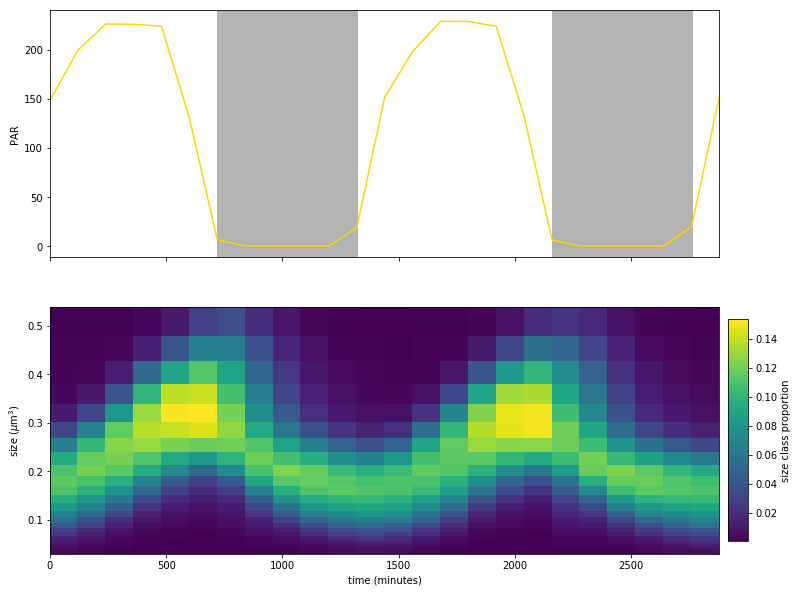

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.set(ylabel='PAR')
for iday in range(2):
    ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
    
ax = axs[1]
pc = ax.pcolormesh(data_gridded['time'],v,data_gridded['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [5]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
mcmcs = {}
models = {}

for k in ('m','v_min','delta_v_inv','obspopsum'):
    data[k] = data_gridded[k]

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
data['E'] = data_gridded['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_gridded['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obspopsum'] = data['obspopsum'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]

# for now, add pseudo-count data
data['obs_count'] = (1000*data['obs']).astype(int)
# load cross-validation testing indices and add them to data
data['i_test'] = np.loadtxt('data/Zinser_SizeDist_calibrated-26-6-itest.csv').astype(int)
# remove last index, so that dimensions agree
data['i_test'] = data['i_test'][:-1]
if len(data['i_test']) != data['nt_obs']:
    raise ValueError('Invalid number of testing indices (expected {}, got {}).'.format(data['nt_obs'],len(data['i_test'])))

# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=data_gridded['PAR'])
'''
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.plot(t, data['E'], color='orange', ls=':')
ax.set(ylabel='PAR')
for iday in range(2):
    ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
'''
None

### load various models and modify prior for some of them

In [6]:
import re

stan_files = {
    'freedelta_respv2_lightsig':'stancode/matrixmodel_estinilnorm_freedelta-lightsig_respv2_normparam_trackgrowth_popsum.stan',
    'freedelta_respiv2_lightsig':'stancode/matrixmodel_estinilnorm_freedelta-lightsig_respiv2_normparam_trackgrowth_popsum.stan',
    #'monodelta_resp_gammaiv3_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_resp_gammaiv3_normparam_trackgrowth_popsum_xval.stan',
    #'monodelta_respiv5_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv5_normparam_trackgrowth_xval.stan',
    #'monodelta_respiv4_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv4_normparam_trackgrowth_popsum_xval.stan',
    'monodelta_respiv6_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_popsum_xval.stan',
    }
desc = {
    'freedelta_respv2_lightsig':'OLD: respiration v2, "free" deltas, light-dep div',
    'freedelta_respiv2_lightsig':'OLD: size-dep respiration v2, "free" deltas, light-dep div',
    'monodelta_resp_gammaiv3_mn':'size-dep growth v3 (exp), simple resp, monotone deltas (exp AR1), multinomial',
    'monodelta_respiv5_mn':'size-dep growth/resp v5 (sep exp), monotone deltas (exp AR1), multinomial',
    'monodelta_respiv4_mn':'size-dep growth/resp v4 (sep exp), monotone deltas (exp AR1), multinomial',
    'monodelta_respiv6_mn':'size-dep growth/resp v6 (sep exp), monotone deltas (exp AR1), multinomial',
}

stan_codes = {}
for name in stan_files:
    with open(stan_files[name]) as f:
        stan_codes[name] = f.read()

In [7]:
import pystan

refit_required = {}
for name in stan_files:
    with open(stan_files[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=stan_files[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_respv2_lightsig NOW.


freedelta_respv2_lightsig: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_respiv2_lightsig NOW.


freedelta_respiv2_lightsig: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv6_mn NOW.


monodelta_respiv6_mn: compiling


In [8]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

try_again = True
refit_all = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name in mcmcs:
        if not refit_all and not refit_required[name]:
            print('{} ({})'.format(name, desc[name])) 
            print('\n'.join(x for x in mcmcs[name].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
            rhat_max = get_max_rhat(mcmcs[name])
            if try_again and rhat_max >= 1.1:
                print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
            else:
                continue
    else:
        mcmcs[name] = {}
    for itry in range(3):
        mcmcs[name] = models[name].sampling(data=data, iter=2000)
        # get max Rhat
        rhat_max = get_max_rhat(mcmcs[name])
        if rhat_max < 1.1:
            break
        print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
    print('{} ({})'.format(name, desc[name])) 
    print('\n'.join(x for x in mcmcs[name].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

freedelta_respv2_lightsig (OLD: respiration v2, "free" deltas, light-dep div)
Inference for Stan model: freedelta_respv2_lightsig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%      25%     50%     75%   97.5%  n_eff   Rhat
delta_mu             1.94  7.9e-3    0.41    1.21     1.66    1.93    2.19     2.8   2634    1.0
delta_sigma          1.74  7.9e-3    0.35    1.15     1.48     1.7    1.95    2.52   1988    1.0
delta_max[1]         1.45    0.02    1.07    0.07     0.62    1.24    2.06    4.04   2849    1.0
delta_max[2]         1.16    0.02    0.94    0.05     0.47    0.96     1.6    3.56   3678    1.0
delta_max[3]         1.03    0.01    0.85    0.04     0.39    0.82    1.42    3.19   3965    1.0
delta_max[4]         0.78    0.01    0.66    0.03     0.29    0.61     1.1    2.51   3133    1.0
delta_max[5]         0.54  7.4e-3    0.46    0.03      0.2    0.43    0.

freedelta_respiv2_lightsig (OLD: size-dep respiration v2, "free" deltas, light-dep div)
Inference for Stan model: freedelta_respiv2_lightsig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd     2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_mu             1.91  8.4e-3     0.4     1.16    1.64    1.89    2.16    2.75   2343    1.0
delta_sigma           1.7  7.3e-3    0.34     1.15    1.45    1.66     1.9    2.46   2196    1.0
delta_max[1]         1.36    0.02    1.01     0.07    0.58    1.17    1.92    3.95   3564    1.0
delta_max[2]         1.08    0.01    0.81     0.07    0.47    0.91     1.5    3.12   3336    1.0
delta_max[3]         0.88    0.01    0.76     0.03    0.32    0.69    1.22    2.92   3885    1.0
delta_max[4]         0.65  8.7e-3    0.53     0.03    0.26    0.53    0.89    2.01   3667    1.0
delta_max[5]         0.47  6.8e-3    0.38     0.02    0.18   

## Plot the results

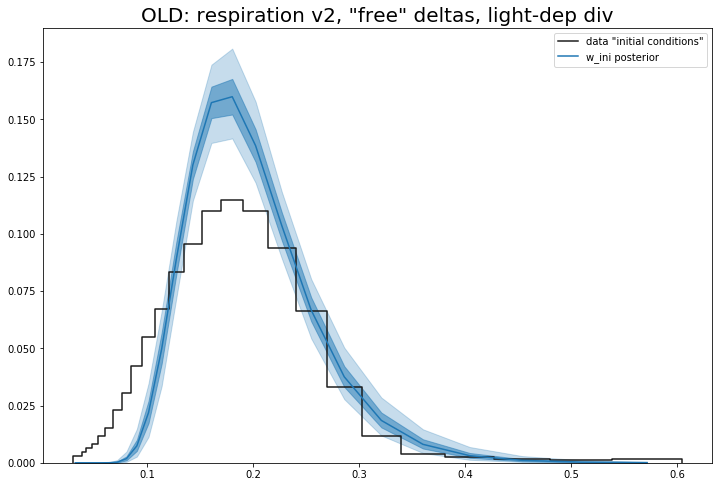

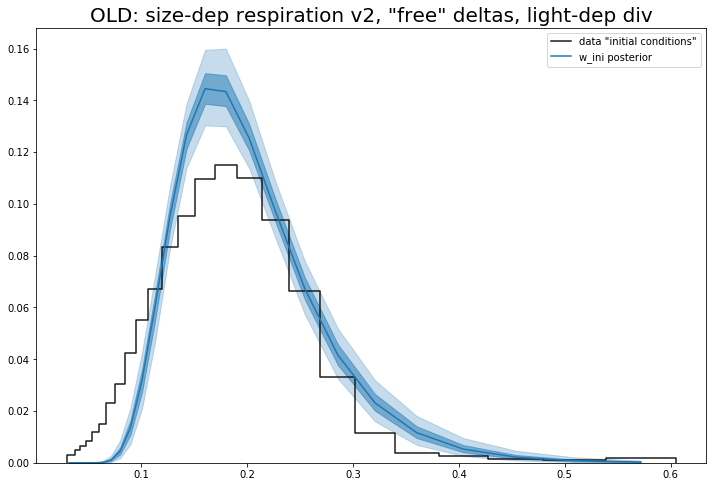

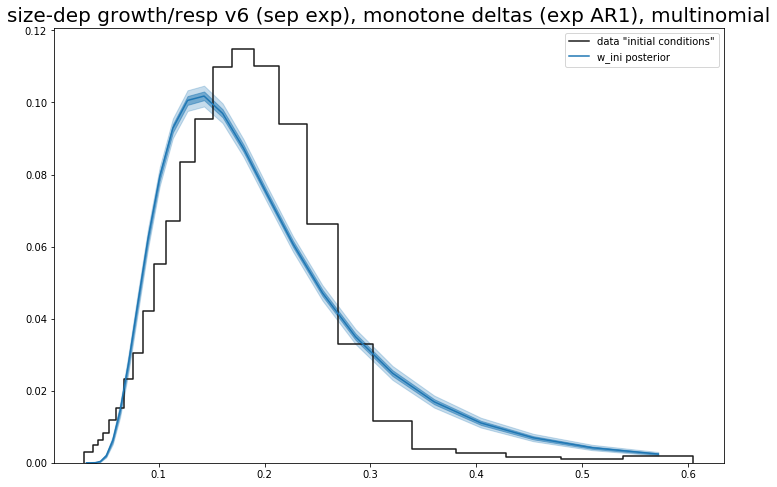

In [9]:
for name,mcmc in mcmcs.items():
    if 'w_ini[1]' in mcmc.flatnames:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title(desc[name], size=20)

        plotdata_y = np.zeros(2*(data_gridded['m']+1))

        delta_v = 1.0/data_gridded['delta_v_inv']
        v_ext = data_gridded['v_min'] * 2**(np.arange(data_gridded['m']+1)*delta_v)
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]

        v_mid = 0.5*(v_ext[1:]+v_ext[:-1])

        cdata = data_gridded['w_obs'][:,0]
        plotdata_y[1:-1] = np.repeat(cdata,2)

        ax.plot(np.repeat(v_ext,2), plotdata_y, color='0.1', label='data "initial conditions"')

        quantiles = np.percentile(mcmc['w_ini'], (5,25,50,75,95), axis=0)

        ax.fill_between(v_mid, quantiles[0,:], quantiles[-1,:], color='C0', alpha=0.25)
        ax.fill_between(v_mid, quantiles[1,:], quantiles[-2,:], color='C0', alpha=0.5)
        ax.plot(v_mid, quantiles[2,:], color='C0', label='w_ini posterior')

        ax.set_ylim(bottom=0.0)
        ax.legend()
None

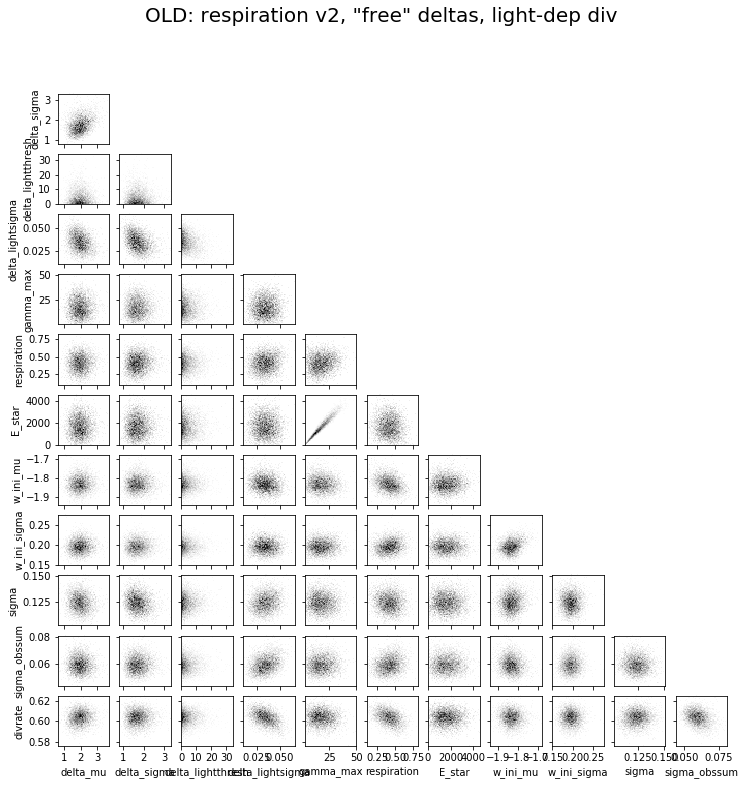

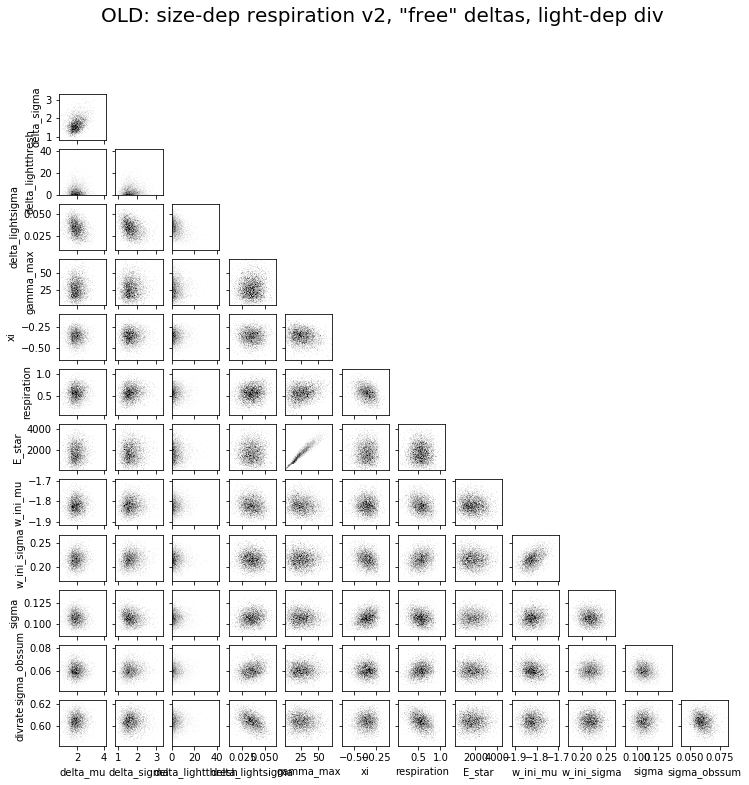

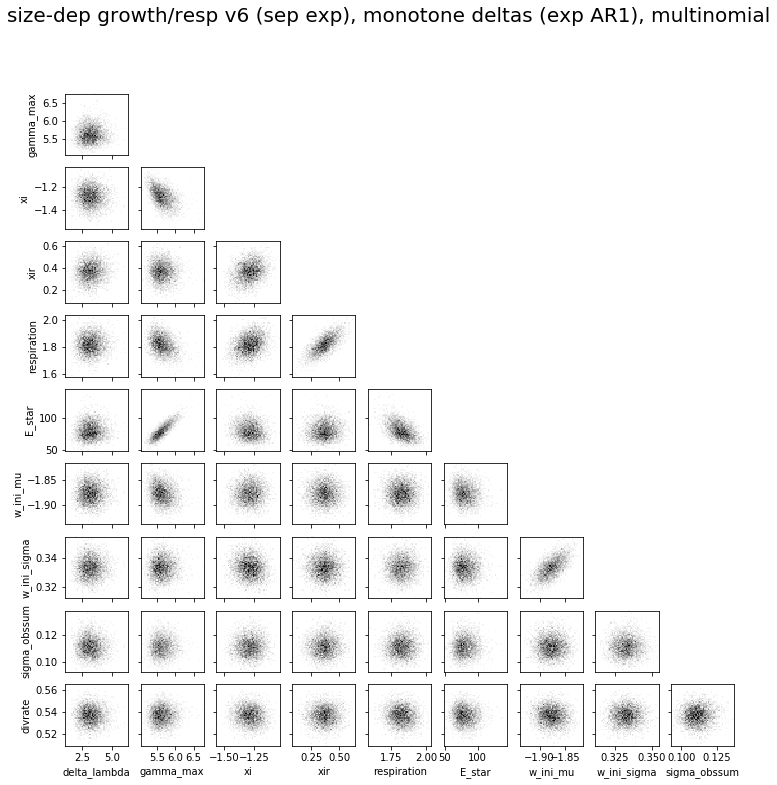

In [10]:
for name,mcmc in mcmcs.items():
    paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max') and not v.startswith('w_ini[')]
    num_params = len(paramnames)

    fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
    fig.suptitle(desc[name], size=20)
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            xname = paramnames[icol]
            yname = paramnames[irow]
            ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
            if icol == 0:
                ax.set_ylabel(yname)
            if irow == num_params-1:
                ax.set_xlabel(xname)

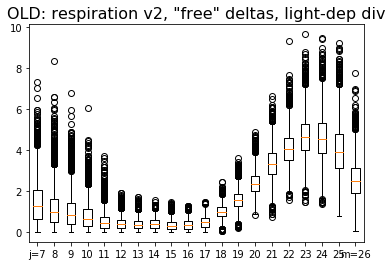

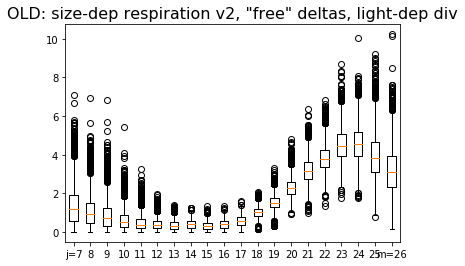

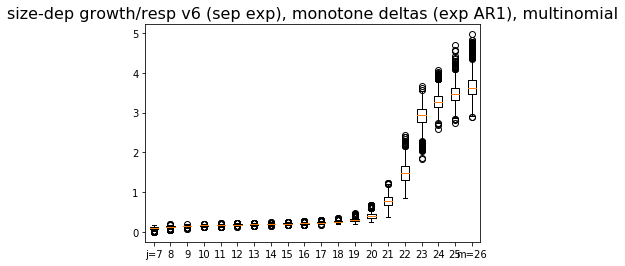

In [11]:
for name,mcmc in mcmcs.items():
    j = data_gridded['delta_v_inv'] + 1
    m = data_gridded['m']
    
    fig, ax = plt.subplots()
    ax.set_title(desc[name], size=16)
    ax.boxplot(mcmc['delta_max'])
    xlabels = [str(x) for x in range(j,m+1)]
    xlabels[0] = 'j='+xlabels[0]
    xlabels[-1] = 'm='+xlabels[-1]
    ax.set_xticklabels(xlabels)
    None

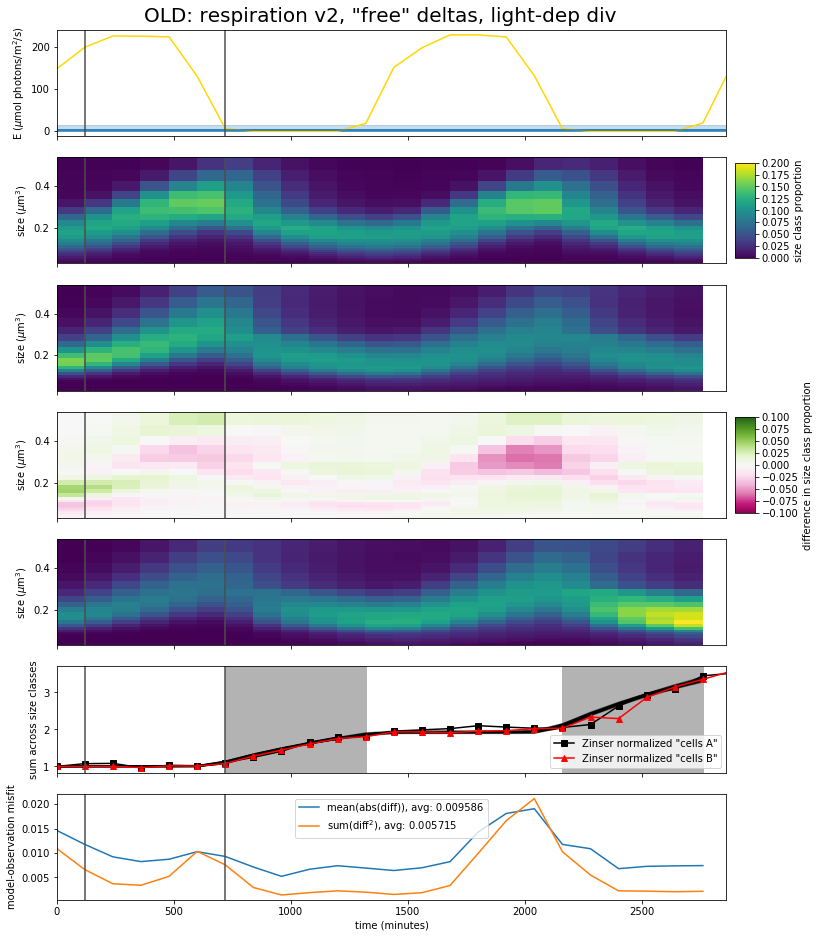

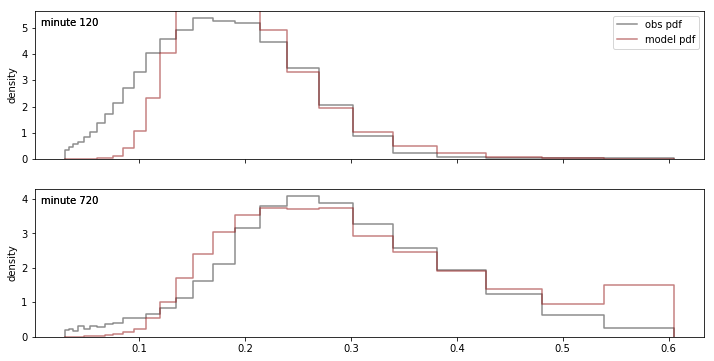

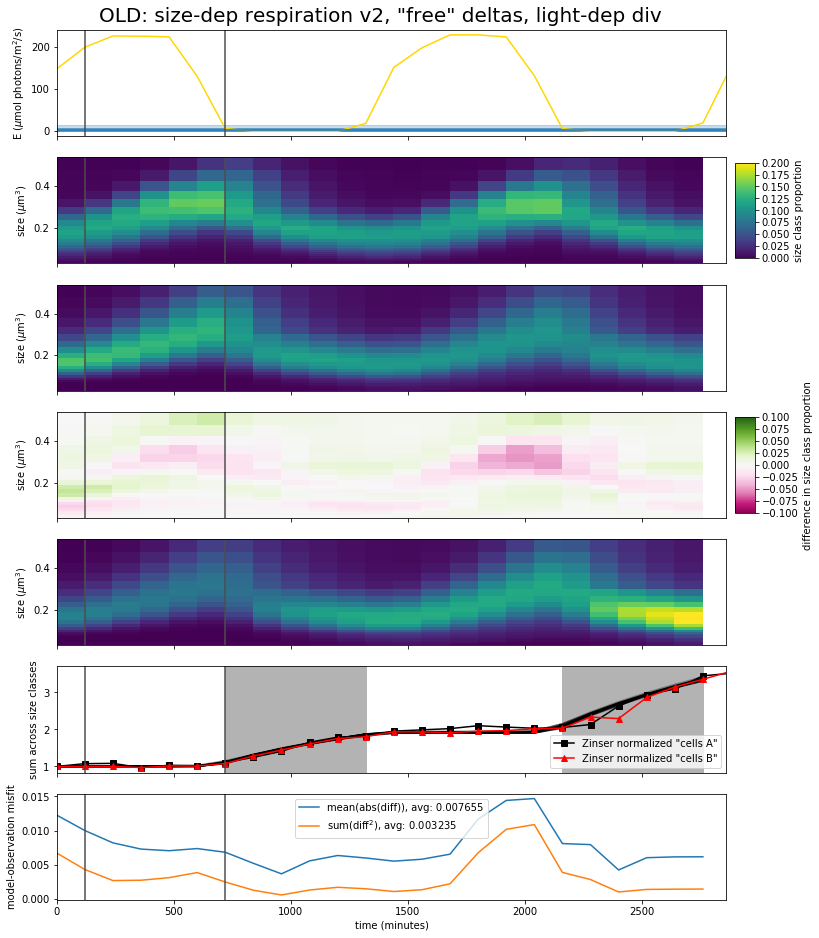

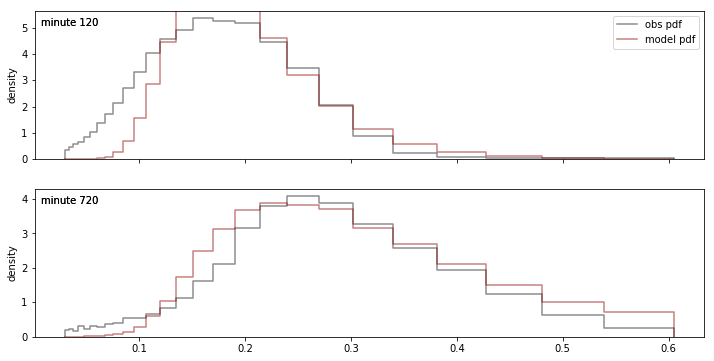

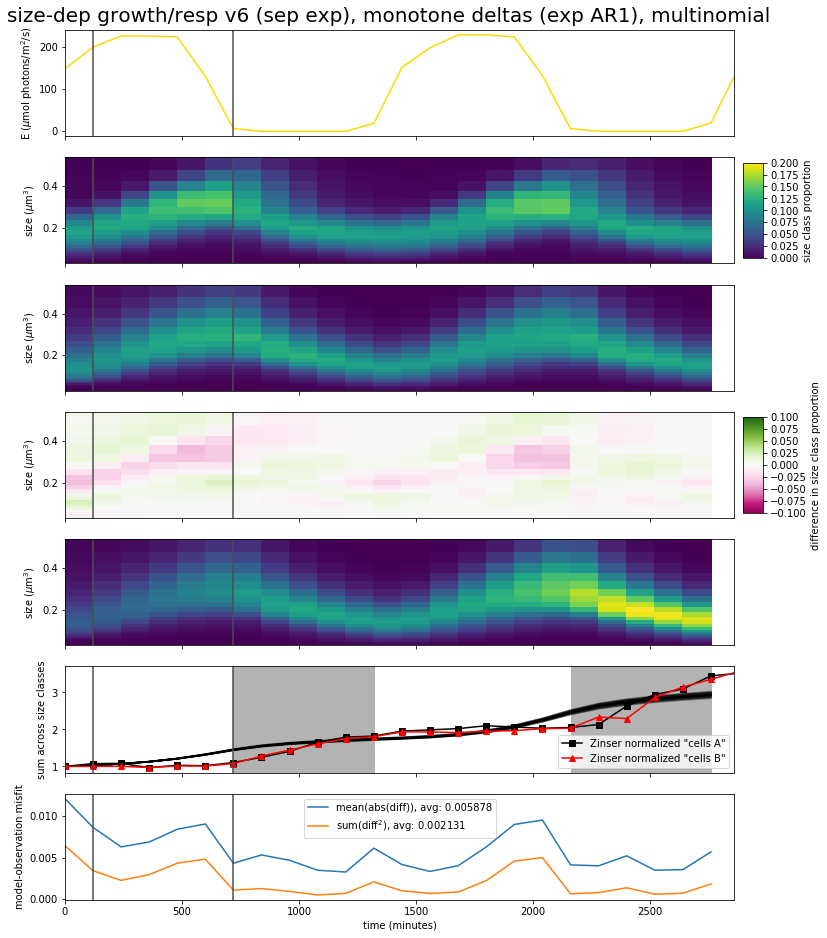

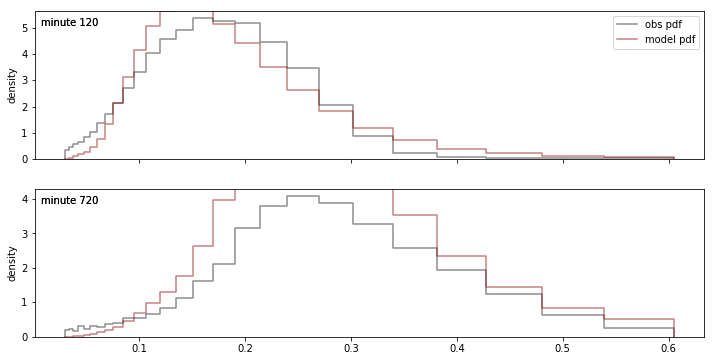

In [12]:
colors = {'model':'darkred', 'obs':'0.1'}

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
    res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
    diff = res_sum1-res['obs']

    fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
    fig.suptitle(desc[name], size=20, y=0.9)
    
    ax = axs[0]
    ax.plot(t, data['E'], color='gold')
    ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')
    if 'delta_lightthresh' in mcmc.flatnames:
        qq = np.percentile(mcmc['delta_lightthresh'], (5,25,50,75,95))
        ax.axhspan(qq[0], qq[-1], color='C0', alpha=0.25)
        ax.axhspan(qq[1], qq[-2], color='C0', alpha=0.5)
        ax.axhline(qq[2], color='C0')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res_sum1,norm=norm)

    ax = axs[3]
    pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

    ax = axs[4]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res['model'])

    ax = axs[5]
    ax.plot(data['t_obs'], np.sum(res['model'],axis=0))
    ax.plot(data['t_obs'], np.sum(mcmc['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
    ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
    ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
    for iday in range(2):
        ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
    ax.legend()
    ax.set(ylabel='sum across size classes')

    ax = axs[6]
    prop = np.mean(np.abs(diff),axis=0)
    ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
    prop = np.sum(diff**2,axis=0)
    ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
    ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
    ax.legend()

    for ax in axs.flat:
        for i in slice_indices:
            ax.axvline(data['t_obs'][i], color='.3')

    # plot slices

    plotdata_y = np.zeros(2*(data['m']+1))

    fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
    for i,ax in zip(slice_indices,axs.flat):
        for name in ('obs','model'):
            color = colors[name]
            cdata = res[name][:,i]
            plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
            ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
            ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
            ax.set_ylabel('density')
            ax.set_ylim(bottom=0.0)
    axs[0].legend()
    None

### a look at growth and respiration as a function of light and size (not size-dependent for all models)

[[1.         0.99528767 0.99002471 0.98415038 0.97759817 0.97029552
  0.96216353 0.95311683 0.94306355 0.93190538 0.91953794 0.90585136
  0.89073121 0.87405985 0.85571828 0.83558864 0.81355739 0.78951934
  0.76338256 0.73507429 0.70454787 0.67179063 0.63683259 0.59975578
  0.56070362 0.51988987]]


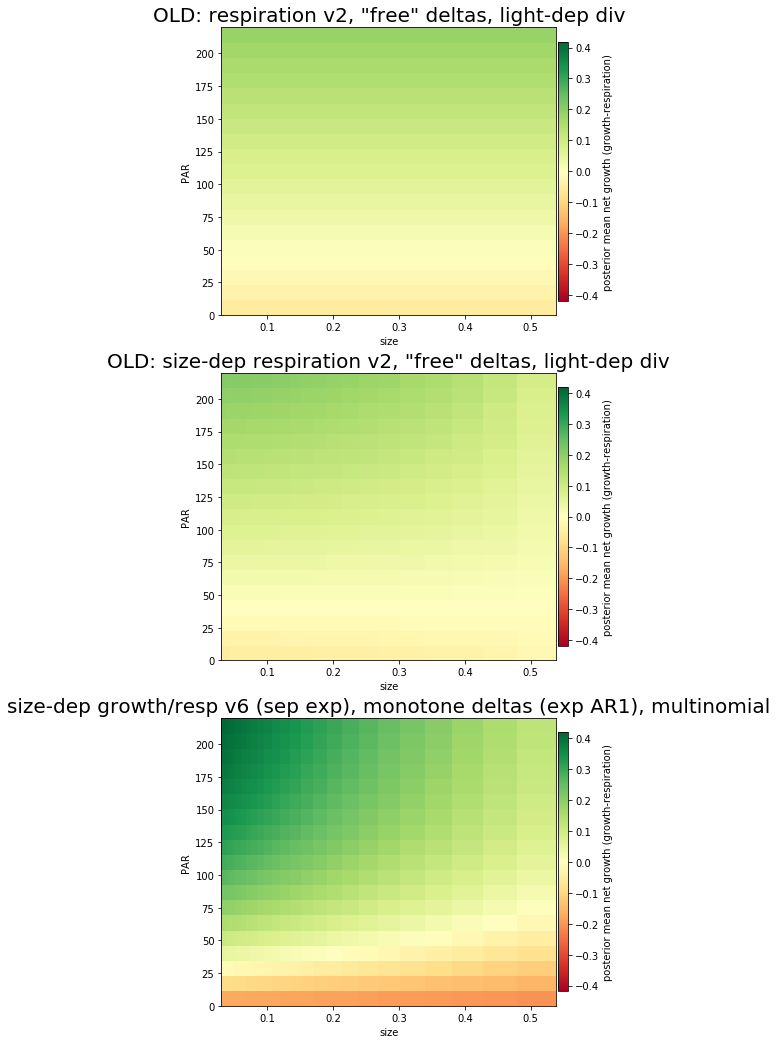

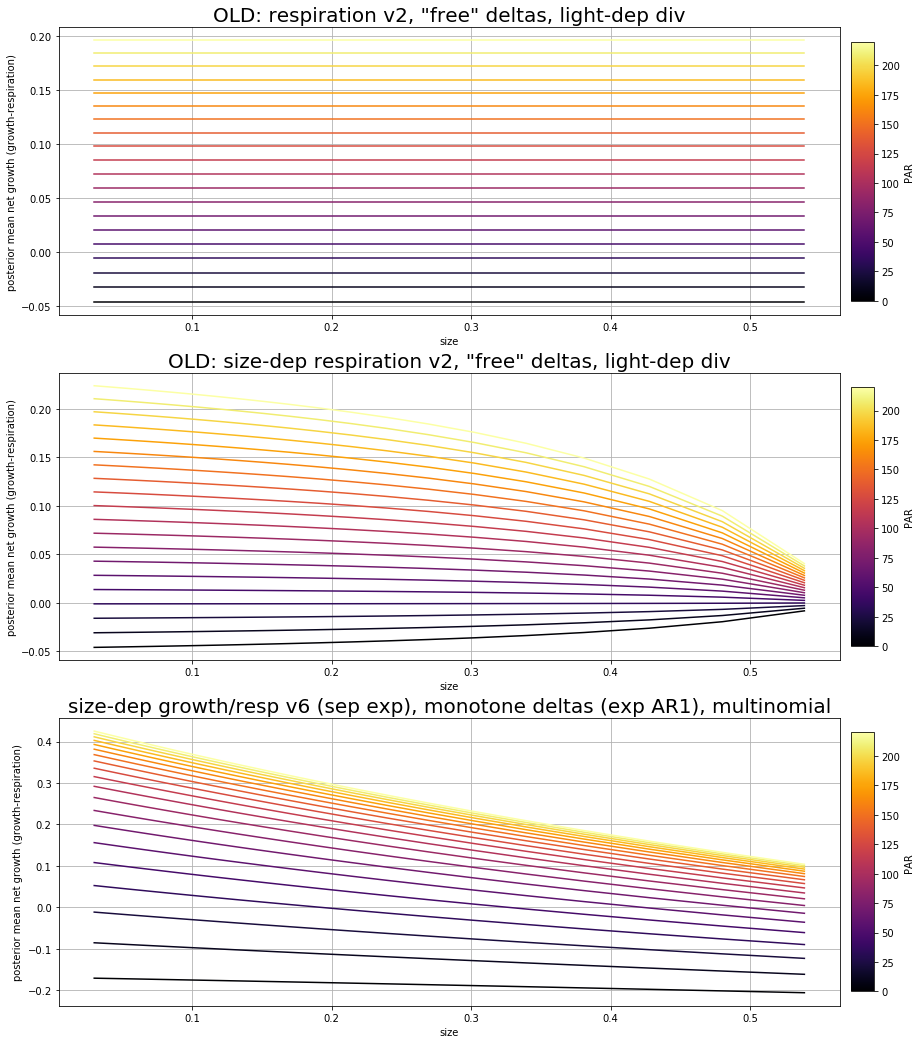

In [16]:
v = (data['v_min'] * 2**(np.arange(data['m'])*delta_v))
v_plot = v[None,:]
e_plot = np.linspace(0.0,220.0,20)[:,None]
ones_plot = np.ones_like(v_plot)

dt_norm = data['dt']/(1440.0 * (2**(1.0/data['delta_v_inv']) - 1.0))
v_min = v[0]
v_max = v[-1]

norm_line = mpl.colors.Normalize(0.0, 220.0)
cmap_line = mpl.cm.inferno

pcs = []
nrows = len(mcmcs)
fig, axs = plt.subplots(nrows=nrows, figsize=(6,6*nrows), squeeze=False)
fig_line, axs_line = plt.subplots(nrows=nrows, figsize=(14,6*nrows), squeeze=False)

for i,name in enumerate(mcmcs):
    mcmc = mcmcs[name]
    params = {p:np.mean(mcmc[p]) for p in ('gamma_max','E_star','respiration','xi','xir') if p in mcmc.flatnames}
    if 'respiv2' in stan_files[name]:
        if params['xi'] > 0:
            tmp = v_plot/v_max
            sizelim = tmp/(params['xi']+tmp)
        else:
            tmp = 1.0 + (v_min-v_plot)/v_max
            sizelim = tmp/(tmp-params['xi'])
        gamma = dt_norm * sizelim * (params['gamma_max'] * (1.0 - np.exp(-e_plot/params['E_star'])) - params['respiration'])
    elif 'respv2' in stan_files[name]:
        gamma = ones_plot * dt_norm * (params['gamma_max'] * (1.0 - np.exp(-e_plot/params['E_star'])) - params['respiration'])
    elif 'respiv3' in stan_files[name]:
        if params['xi'] > 0:
            sizelim = np.exp(params['xi']*v_plot)
        else:
            sizelim = np.exp(params['xi']*(v_plot-v_min-v_max))
        gamma = dt_norm * sizelim * (params['gamma_max'] * (1.0 - np.exp(-e_plot/params['E_star'])) - params['respiration'])
    elif 'resp_gammaiv3' in stan_files[name]:
        # sizelim is not applied to respiration
        if params['xi'] > 0:
            sizelim = np.exp(params['xi']*v_plot)
        else:
            sizelim = np.exp(params['xi']*(v_plot-v_min-v_max))
        gamma = dt_norm * (sizelim * params['gamma_max'] * (1.0 - np.exp(-e_plot/params['E_star'])) - params['respiration'])
    elif 'respiv4' in stan_files[name]:
        gamma = None
        message = 'no net growth\ngrowth and respiration are separate'
    elif 'respiv5' in stan_files[name]:
        if params['xi'] > 0:
            sizelim = np.exp(params['xi']*v_plot)
        else:
            sizelim = np.exp(params['xi']*(v_plot-v_min-v_max))
        gamma = dt_norm * sizelim * params['gamma_max'] * (1.0 - np.exp(-e_plot/params['E_star']))
        if params['xir'] > 0:
            sizelim = np.exp(params['xir']*v_plot)
        else:
            sizelim = np.exp(params['xir']*(v_plot-v_min-v_max))
        gamma -= dt_norm * sizelim * params['respiration']
    elif 'respiv6' in stan_files[name]:
        if params['xi'] > 0:
            sizelim = np.exp(params['xi']*(v_plot-v_max))
        else:
            sizelim = np.exp(params['xi']*(v_plot-v_min))
        gamma = dt_norm * sizelim * params['gamma_max'] * (1.0 - np.exp(-e_plot/params['E_star']))
        if params['xir'] > 0:
            sizelim = np.exp(params['xir']*(v_plot-v_max))
        else:
            sizelim = np.exp(params['xir']*(v_plot-v_min))
        gamma -= dt_norm * sizelim * params['respiration']
    elif 'respiv7' in stan_files[name]:
        gamma = None
        message = 'no net growth\ngrowth and respiration are separate'
    else:
        raise RuntimeError('No support for growth/respiration formulation in "{}".'.format(name))
    
    ax = axs.flatten()[i]
    ax.set_title(desc[name], size=20)
    if gamma is None:
        ax.text(0.5,0.5,message,size=20,ha='center',va='center',transform=ax.transAxes)
    else:
        pc = ax.pcolormesh(v_plot, e_plot, gamma, cmap=plt.get_cmap('RdYlGn'))
        ax.set(xlabel='size', ylabel='PAR')
    
    pcs.append(pc)
    
    # second plot
    
    ax = axs_line.flatten()[i]
    ax.set_title(desc[name], size=20)
    if gamma is None:
        ax.text(0.5,0.5,message,size=20,ha='center',va='center',transform=ax.transAxes)
    else:
        for i,e in enumerate(e_plot.flat):
            ax.plot(v_plot.flatten(), gamma[i,:], label='PAR = {}'.format(e), color=cmap_line(norm_line(e)))
    #ax.axhline(0.0, color='0.5')
    ax.grid(True)
    ax.set(xlabel='size', ylabel='posterior mean net growth (growth-respiration)')
    add_colorbar(ax, norm=norm_line, cmap=cmap_line, label='PAR')
    
# adjust all norms
vmax = -1.0
for pc in pcs:
    vmax = max(vmax, -pc.norm.vmin)
    vmax = max(vmax, pc.norm.vmax)
for pc in pcs:
    pc.norm.vmin = -vmax
    pc.norm.vmax = vmax

for ax,pc in zip(axs.flat,pcs):
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='posterior mean net growth (growth-respiration)')

## general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 